In [1]:
!pip install pandas numpy matplotlib scipy seaborn scikit-learn xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
data = pd.read_csv("CC GENERAL 3.csv")
data.head()

,CUST_ID,GENDER,LOCATION,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,IS_RISKY_PAYER
0,C10001,Female,Nablus,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,12,1
1,C10002,Male,Nablus,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,12,0
2,C10003,Male,Jenin,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,12,1
3,C10004,Male,Tulkarm,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,12,0
4,C10005,Male,Tulkarm,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,12,1


In [4]:
data.columns

Index(['CUST_ID', 'GENDER', 'LOCATION', 'BALANCE', 'BALANCE_FREQUENCY',
       'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'TENURE', 'IS_RISKY_PAYER'],
      dtype='object')

### After analyzing each feature and what it represents, this is the conclusion I have reached:
- Categorical Data:
    - Customer ID: Each customer has a unique ID, therefore, the first step would be to check weather a Customer made one purchase or multiple purchases to decide whether to keep this column or not.
    - Gender: Each customer has a gender which is either a male or female, therefore, it can be turned to a binary value, and might be helpful to determine behavioural population density based on their representative data rows, this will be turned into discrete numerical values for computational efficiency.
    - Location: Each customer has done their purchase from a certain place, therefore, it can be turned to a map of values, which will help determine which areas most purchases occured at, this will be turned into discrete numerical values for computational efficiency.

In [5]:
# Checking whether to keep or remove Customer ID (If the value is True then each customer made only one purchase, therefore, it won't add much information to the AI, since each
# row already represents an ID, otherwise, if the value was False, then an aggregation operation is due, since we can accumulate multiple entrances for each customer)

len(data['CUST_ID'].unique()) == len(data)

True

It's settled, Customer ID is going to be removed from the dataset

In [6]:
data = data.drop('CUST_ID', axis=1)
data.head()

,GENDER,LOCATION,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,IS_RISKY_PAYER
0,Female,Nablus,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,12,1
1,Male,Nablus,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,12,0
2,Male,Jenin,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,12,1
3,Male,Tulkarm,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,12,0
4,Male,Tulkarm,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,12,1


The rest of the values are obviously Numerical since we've determined the Categorical, now the next step is to determine which is continuous and which is discrete

In [7]:
numerical_cols = data.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
numerical_cols

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE',
       'IS_RISKY_PAYER'],
      dtype='object')

In [8]:
discrete_columns = []
continuous_columns = []

for col in numerical_cols:
    if pd.api.types.is_integer_dtype(data[col]) or all(data[col].dropna() == data[col].dropna().astype(int)):
        discrete_columns.append(col)
    else:
        continuous_columns.append(col)

In [9]:
print("Discrete: ", discrete_columns)
print("Continuous: ", continuous_columns)

Discrete:  ['CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE', 'IS_RISKY_PAYER']
Continuous:  ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']


Now that we've determined each type of these columns, we can dig deeper into the details of these columns, by processing the missing values, understanding the distribution of each column, and anlyzing how to handle each column for the AI, so basic Data Science steps:

In [10]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage

GENDER                              0.000000
LOCATION                            0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011173
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.497207
TENURE                              0.000000
IS_RISKY_PAYER                      0.000000
dtype: float64

So we conclude from the previous data, that the percentage (out of 100) is maximum 3%, if it was bigger we would've taken different steps to deal with the data such as deleting the column (as it won't add much to the model), however, since the columns are under low rates of missing data, we can conclude that it's best we fill this data.

Knowing that the type of the both of the columns is Continous based on the previous data check, we can determine the method in which we will fill the data, and in this case, I believe mean imputation would be the best approach to this case.

In [11]:
# Filling both columns with the mean of the column in order to fill the missing data.

data['CREDIT_LIMIT'] = data['CREDIT_LIMIT'].fillna(data['CREDIT_LIMIT'].mean())
data['MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].fillna(data['MINIMUM_PAYMENTS'].mean())

And now to double-check:

In [12]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage

GENDER                              0.0
LOCATION                            0.0
BALANCE                             0.0
BALANCE_FREQUENCY                   0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
TENURE                              0.0
IS_RISKY_PAYER                      0.0
dtype: float64

Now moving on to the next step, which is to dig deeper into data to understand further details

In [13]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,IS_RISKY_PAYER
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,11.517318,0.445475
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.612411,2895.063757,2330.588021,1.338331,0.497046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,6.000000,0.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,12.000000,0.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,12.000000,0.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,864.206542,12.000000,1.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,12.000000,1.000000


We might use these stats later, it's good knowing generic details about the data regardless, moving on, visualizing the data:

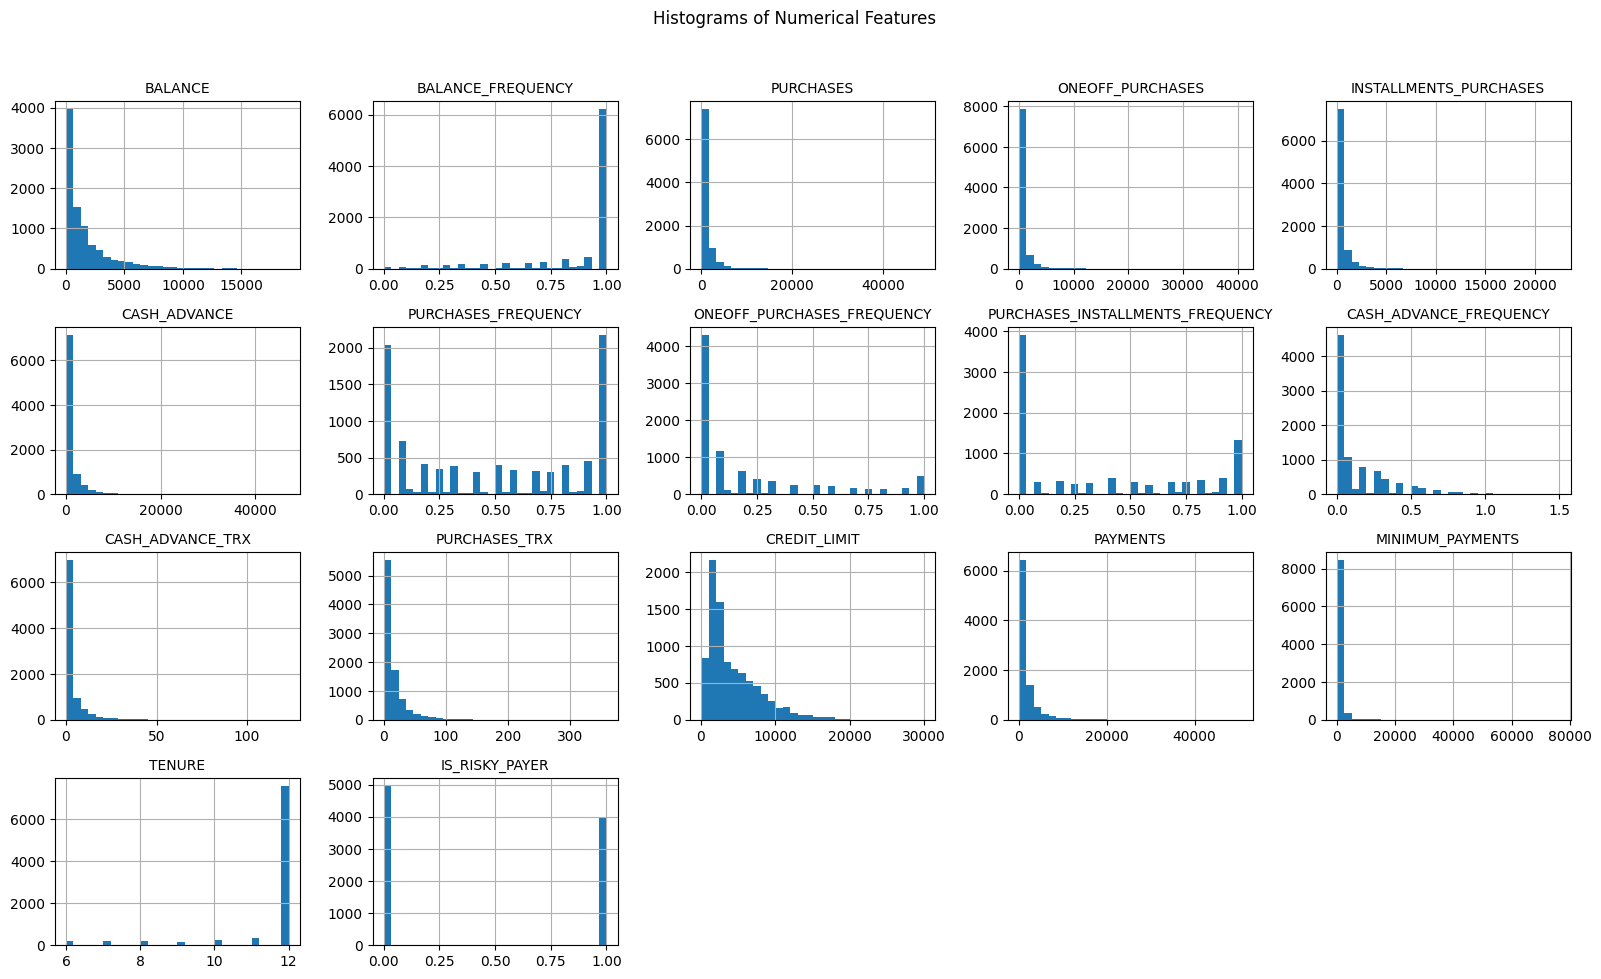

In [14]:
axes = data[numerical_cols].hist(figsize=(16, 12), bins=30, layout=(5, 5))

for ax in axes.flatten():
    if ax is not None: 
        ax.set_title(ax.get_title(), fontsize=10) 

plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

Quick observation on my end, most data attributes are tending to be skewed to the left side, which is something not preferred in the world of data science, we can do something to help figure out a better solution for the data, which won't affect the data itself however, it would help normalize it better, I believe using an approach like log transformation or cox-box transformation would help normalize the data further.

In [15]:
# Applying the log transformation on the columns:

transformation_columns = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

for col in transformation_columns:
    data[col] = np.log1p(data[col])

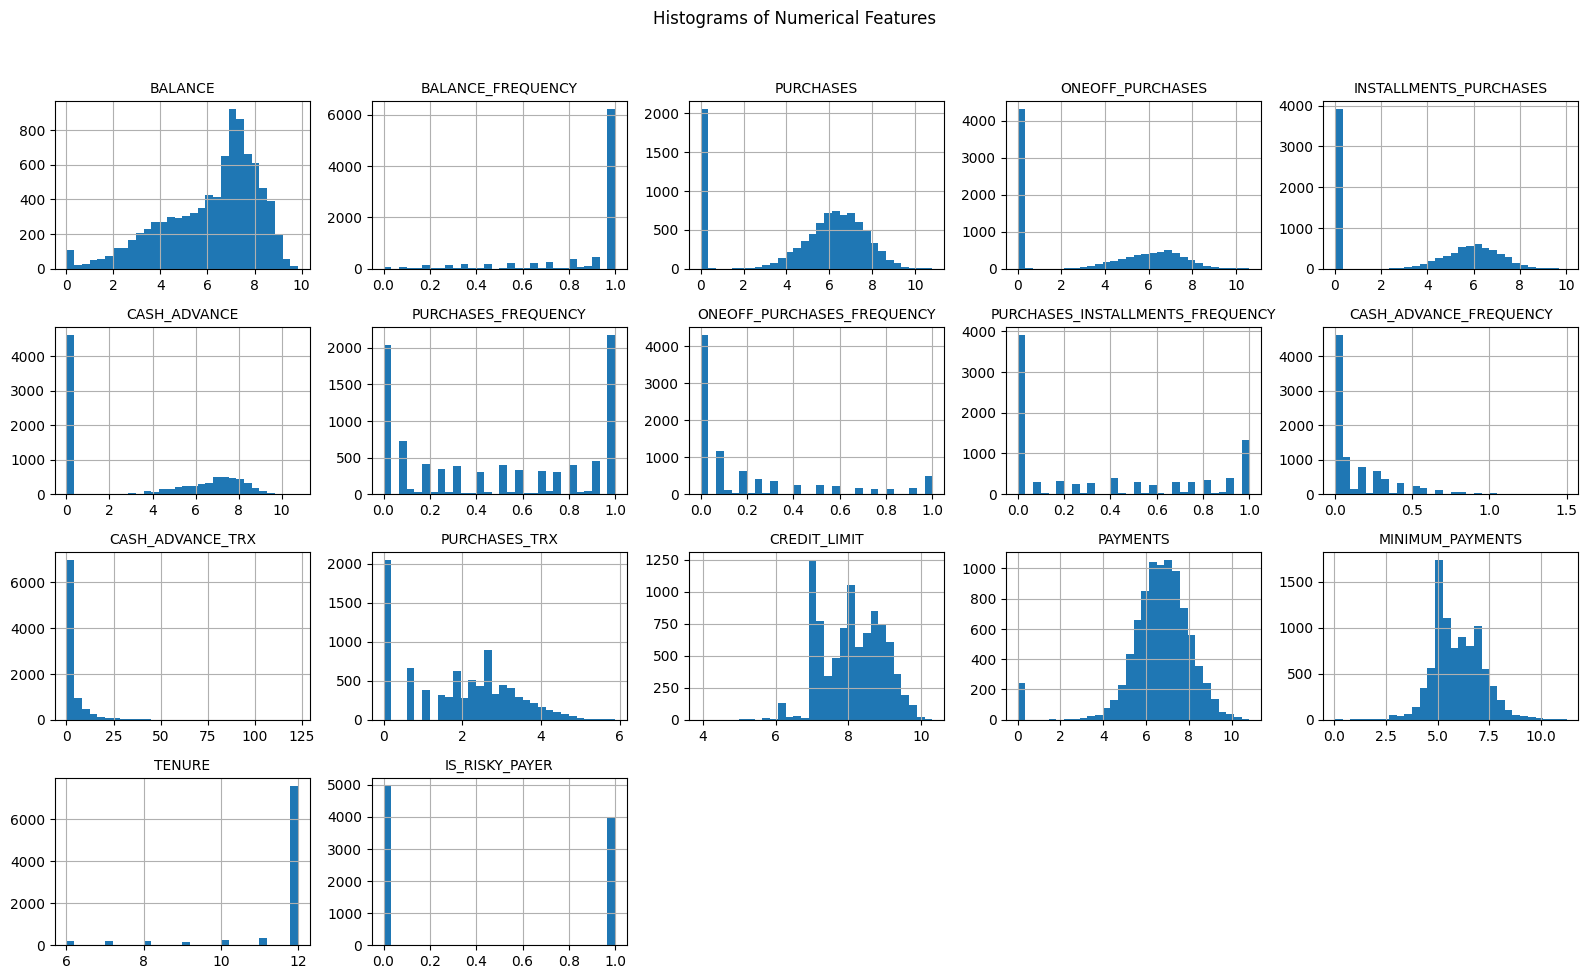

In [16]:
# Now displaying:

axes = data[numerical_cols].hist(figsize=(16, 12), bins=30, layout=(5, 5))

for ax in axes.flatten():
    if ax is not None: 
        ax.set_title(ax.get_title(), fontsize=10) 

plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

Now to check the correlation between columns to see which ones are quite similar to others, we need to create a correlation matrix as follows:

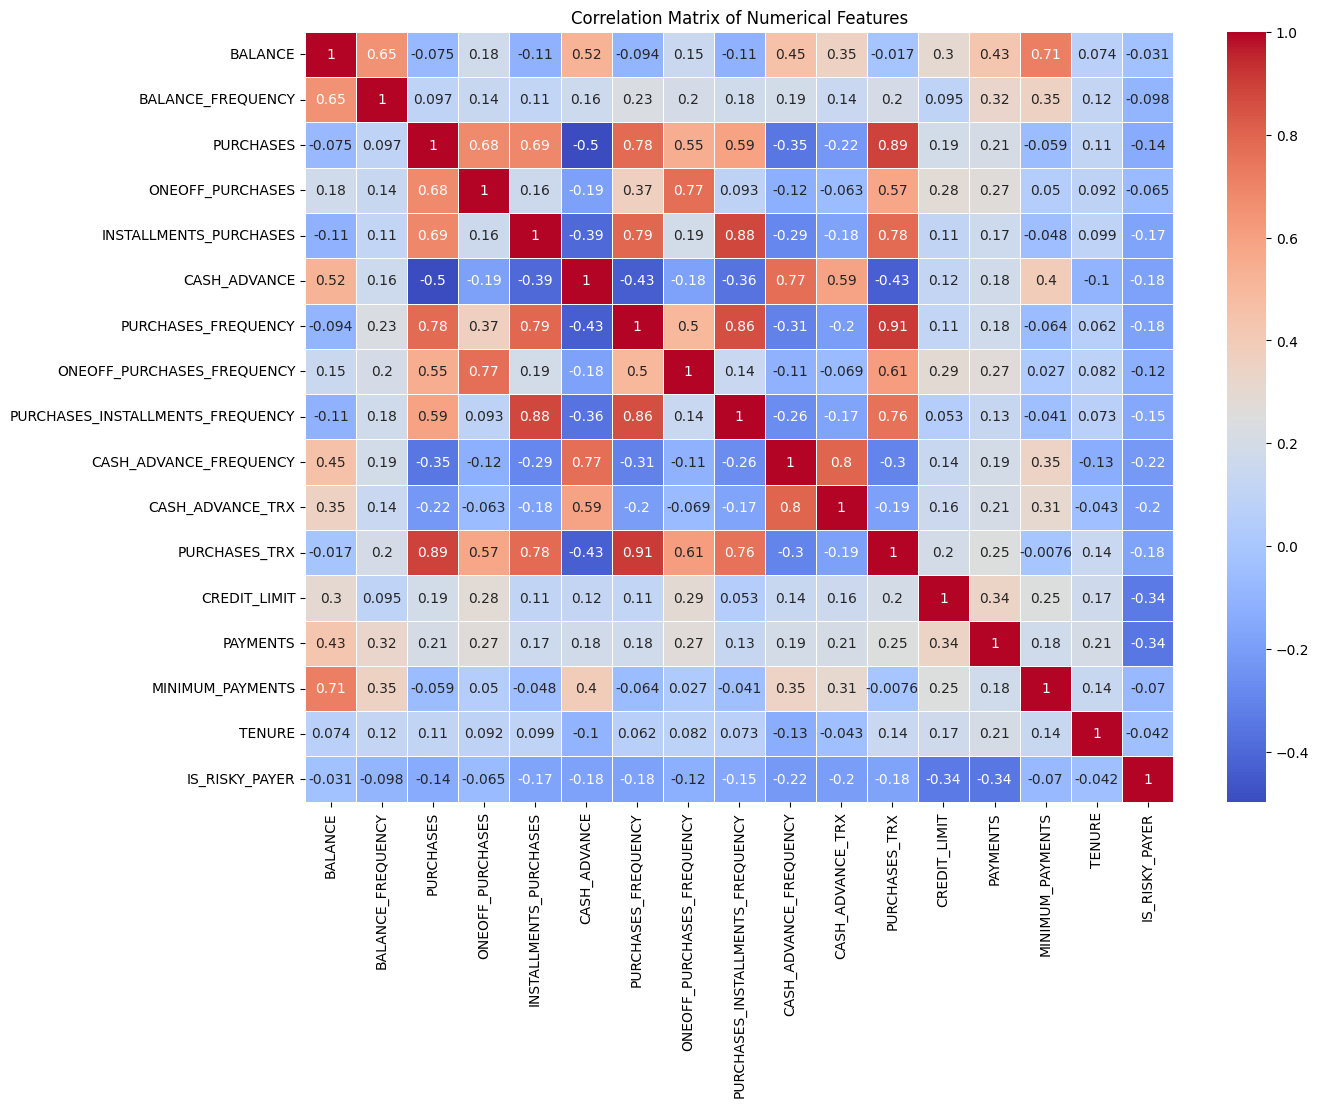

In [17]:
numerical_data = data[numerical_cols]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

To ensure there isn't any type of redundancy in data between columns, we need to remove one out of two columns that have a correlation above 85% as a threshold (the threshold thing is debatable, however, due to sensitivity of simplistic models, it's regularly preferred if we remove ones with high correlation)

Now normally, to choose which one of these features is to go and which one to stay, we usually do a standard measure called an upper triangle, in order to decide which features have less correlation percentage with other features so that they can stay. Therefore, the features which have 85% correlation, and that have less correlation with other features stay, and the one with more correlation with other features go.

As follows:

In [18]:
# We take the absolute value to take negative and positive values from the matrix, then we remove the lower triangle values in the matrix square (which are redundant) 
# to consider the close correlation, and then we decide which columns to stay and which to go within

correlation_matrix = correlation_matrix.abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
reduced_data = numerical_data.drop(columns=to_drop)

In [19]:
print("Columns dropped due to high correlation (> 0.85):", to_drop)
print("Remaining columns after removing highly correlated features:", list(reduced_data.columns))

Columns dropped due to high correlation (> 0.85): ['PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_TRX']
Remaining columns after removing highly correlated features: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE', 'IS_RISKY_PAYER']


Now that we've decided which columns to stay and which to go, we can go to the next step, which is further *Feature Engineering*, which we already started with by deleting a few columns, now comprehending the details makes the difference, therefore, we need to get to the details of *Feature Engineering*

First step is, we need to determine the *Target Variable*, which makes all the difference in the work, and since the task objective is to "Predict customer who will be risky based on credit card data", then the target variable is "IS_RISKY_PAYER". 

Now that we know the target variable, we need to see how other features might affect this logically.

According to [Credit Utilization Rules](https://www.capitalone.com/learn-grow/money-management/credit-utilization-and-credit-score/), we can conclude that we can extract ratios from the already given values, which gives out even more powerful and precise calculations in the AI algorithm we're going to use.

In [20]:
data['CREDIT_UTILIZATION_RATIO'] = data['BALANCE'] / (data['CREDIT_LIMIT'] + 1)
data['PAYMENT_MIN_PAYMENT_RATIO'] = data['PAYMENTS'] / (data['MINIMUM_PAYMENTS'] + 1)

Averages of Purchase and Payment Amounts Over Time

In [21]:
data['AVG_PURCHASE'] = data['PURCHASES'] / (data['PURCHASES_TRX'] + 1)
data['AVG_PAYMENT'] = data['PAYMENTS'] / (data['TENURE'] + 1)
data['PURCHASE_CONSISTENCY'] = data['PURCHASES'] / (data['TENURE'] + 1)


User Behavior on Credit Cash Usage

In [22]:
data['CASH_ADVANCE_DEPENDENCE_RATIO'] = data['CASH_ADVANCE'] / (data['PURCHASES'] + 1)
data['HIGH_BALANCE_INDICATOR'] = (data['BALANCE'] / (data['CREDIT_LIMIT'] + 1)) > 0.8
data['HIGH_BALANCE_INDICATOR'] = data['HIGH_BALANCE_INDICATOR'].astype(int)
data['TOTAL_TRANSACTIONS'] = data['CASH_ADVANCE_TRX'] + data['PURCHASES_TRX']
data['PAYMENT_FREQUENCY_SCORE'] = data['BALANCE_FREQUENCY'] * data['PAYMENTS']
data['AVG_TRANSACTION_AMOUNT'] = data['PURCHASES'] / (data['TOTAL_TRANSACTIONS'] + 1)

Now turning the categorical values to numerical by using one-hot encoding (Final Feature Engineering task)

In [23]:
categorical_cols = data.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)

data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

Categorical Columns: Index(['GENDER', 'LOCATION'], dtype='object')


Now that we've done some feature engineering, by creating new features and removing unnecessary ones earlier, we can advance to the modeling step

In [24]:
# First of all, defining the Target Variable, as we've already defined, it's "IS_RISKY_PAYER"

X = data.drop(columns=['IS_RISKY_PAYER'])
y = data['IS_RISKY_PAYER']

Splitting the data into 2 partitions, one for training (75% of the original data), and one for testing (25% of the original data)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Normalization and standarization are both important for the process, in order to ensure that there won't be any bias towards a certain attribute (column)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Given that the problem is a classification task, I have decided to train three different models. Normally, a baseline model would be Logistic Regression due to its simplicity. However, I believe that the relationships between features in this data are likely non-linear, therefore, ensemble models are more suitable, I'm using these 3 following models:

- Random Forest Classifier
- XGBoost Trees Classifier
- Support Vector Machines

For a very specific reason, the data size is small to moderate, meaning on simplistic models like Logestic Regression this is going to cause a high bias problem, therefore approaching Ensemble models resolves this issue. And that's why I'm going to go with this approach:

In [27]:
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm = SVC(random_state=42)

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "SVM": svm
}

results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

results_df = pd.DataFrame(results)
print(results_df)

C:\Users\Omar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [01:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.899464   0.908350  0.868549  0.888004
1        XGBoost  0.895442   0.893744  0.876339  0.884956
2            SVM  0.864611   0.876299  0.820837  0.847662


And now one final step, it's not documented or required, however this is a way to perform hyperparameters tuning using grid search:

In [28]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, verbose=2)

In [29]:
best_params = rf_random.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}


And finally, the best approach would be to use the best hyperparameters next time we train the model, in order to train the model on those parameters, which will gurantee the best results

In [30]:
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred_best_rf)
precision = precision_score(y_test, y_pred_best_rf)
recall = recall_score(y_test, y_pred_best_rf)
f1 = f1_score(y_test, y_pred_best_rf)

print("accuracy:", accuracy, ", precision:", precision, ", recall:", recall, ", f1", f1)

accuracy: 0.8958891867739053 , precision: 0.9059304703476483 , recall: 0.8627069133398247 , f1 0.883790523690773


To improve model accuracy and other metrics, I would normally go to the approach of trying more values in hyperparameters grid, in order to ensure that we have a larger scale of parameters, or another approach can be followed, which is randomized search instead of the grid search approach, with creating a validation partition of the set (training, testing, and validation for better folds). Increasing the data would be another way to increase model accuracy, as well as better feature engineering (I'm pretty sure much further features can be extracted).

And finally to use the model we can pickle it using the library pickle, and use it for predictions.
                                                                                                 
And that sums it up, I hope you have a great day!